# Basic Usage

Basic Usage Example for JAXSR.

Demonstrates the core functionality of JAXSR for discovering
algebraic expressions from data.

In [1]:
import jax.numpy as jnp
import numpy as np
from jaxsr import BasisLibrary, SymbolicRegressor, fit_symbolic

## Discover a polynomial expression.

$$y = 2.5\,x_0 + 1.2\,x_0\,x_1 - 0.8\,x_1^2$$

In [2]:
# Generate synthetic data: y = 2.5*x0 + 1.2*x0*x1 - 0.8*x1^2 + noise
np.random.seed(42)
n_samples = 200
X = np.random.randn(n_samples, 2) * 2
y = 2.5 * X[:, 0] + 1.2 * X[:, 0] * X[:, 1] - 0.8 * X[:, 1] ** 2
y += np.random.randn(n_samples) * 0.1

X_jax = jnp.array(X)
y_jax = jnp.array(y)

print("\nTrue model: y = 2.5*x0 + 1.2*x0*x1 - 0.8*x1^2")
print(f"Data: {n_samples} samples, 2 features, noise std=0.1")

# Build basis library
library = (
    BasisLibrary(n_features=2, feature_names=["x0", "x1"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

print(f"\nBasis library: {len(library)} candidate functions")

# Fit model
model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)
model.fit(X_jax, y_jax)

# Results
print("\nDiscovered expression:")
print(f"  {model.expression_}")
print("\nMetrics:")
print(f"  R² score: {model.score(X_jax, y_jax):.6f}")
print(f"  MSE: {model.metrics_['mse']:.6f}")
print(f"  BIC: {model.metrics_['bic']:.2f}")
print(f"  Complexity: {model.complexity_}")


True model: y = 2.5*x0 + 1.2*x0*x1 - 0.8*x1^2
Data: 200 samples, 2 features, noise std=0.1

Basis library: 8 candidate functions



Discovered expression:
  y = - 0.7996*x1^2 + 2.502*x0 + 1.198*x0*x1 - 0.002767*x0^2

Metrics:
  R² score: 0.999827
  MSE: 0.009535
  BIC: -341.78
  Complexity: 7


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
             x1^2    -0.7996    0.0010  -780.22   0.00e+00 [-0.8017, -0.7976] ***
               x0     2.5023    0.0037   672.60   0.00e+00 [2.4950, 2.5096] ***
            x0*x1     1.1983    0.0020   604.49   0.00e+00 [1.1944, 1.2022] ***
             x0^2    -0.0028    0.0011    -2.50   1.33e-02 [-0.0049, -0.0006] *
  --- *** p<0.001, ** p<0.01, * p<0.05


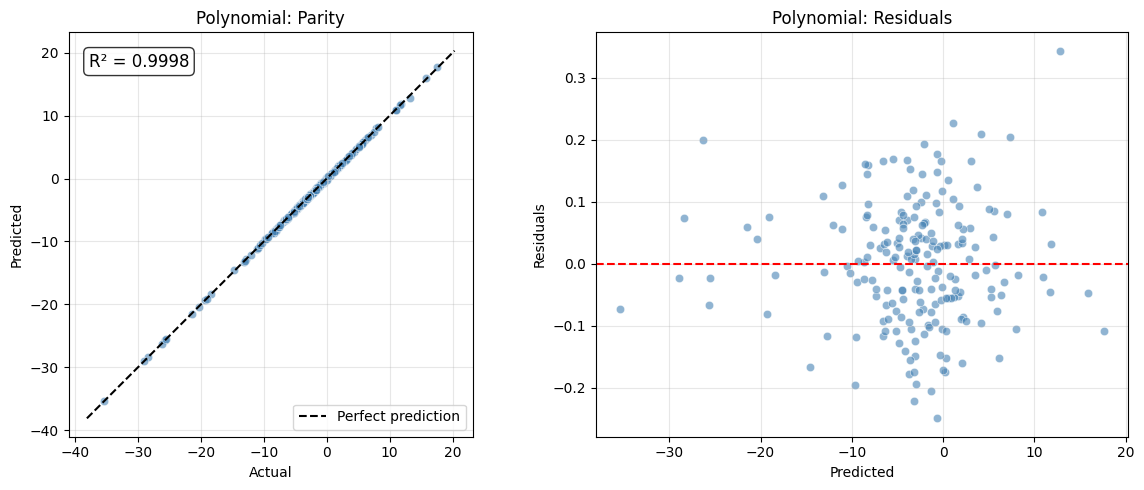


ANOVA Table (Polynomial)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  x1^2                          1     4102.7339     4102.7339   421667.79      0.0000
  x0                            1     3311.9346     3311.9346   340391.60      0.0000
  x0*x1                         1     3577.5786     3577.5786   367693.76      0.0000
  x0^2                          1        0.0608        0.0608        6.25      0.0133
  Model                         3    10992.3078     3664.1026   376586.47      0.0000
  Residual                    196        1.9070        0.0097                        
  Total                       199    10994.2148       55.2473                        
--------------------------------------------------------------------------------

Variance Contributions:
  x1^2                         37.3%  ***
  x0                           30.1%  ***
  x0*x1        

In [3]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
from jaxsr import anova
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y_jax)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_jax)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_jax, y_pred, ax=axes[0], title="Polynomial: Parity")
residuals = np.array(y_jax - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Polynomial: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Polynomial)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover an expression with transcendental functions.

$$y = e^{-0.5\,x} + \ln(x + 1)$$

In [4]:
# Generate data: y = exp(-0.5*x) + log(x+1)
np.random.seed(42)
n_samples = 150
X = np.random.uniform(0.1, 3.0, (n_samples, 1))
y = np.exp(-0.5 * X[:, 0]) + np.log(X[:, 0] + 1)
y += np.random.randn(n_samples) * 0.02

X_jax = jnp.array(X)
y_jax = jnp.array(y)

print("\nTrue model: y = exp(-0.5*x) + log(x+1)")
print(f"Data: {n_samples} samples, 1 feature")

# Build library with transcendental functions
library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_transcendental(["log", "exp", "sqrt"])
)

print(f"\nBasis library: {len(library)} candidate functions")

model = SymbolicRegressor(
    basis_library=library,
    max_terms=6,
    strategy="greedy_forward",
)
model.fit(X_jax, y_jax)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² score: {model.score(X_jax, y_jax):.6f}")


True model: y = exp(-0.5*x) + log(x+1)
Data: 150 samples, 1 feature

Basis library: 7 candidate functions



Discovered expression:
  y = 0.9152 + 0.3777*sqrt(x) + 0.002365*exp(x)
  R² score: 0.983003


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                1     0.9152    0.0075   122.23   0.00e+00 [0.9004, 0.9300] ***
          sqrt(x)     0.3777    0.0095    39.83   0.00e+00 [0.3590, 0.3964] ***
           exp(x)     0.0024    0.0007     3.33   1.10e-03 [0.0010, 0.0038] **
  --- *** p<0.001, ** p<0.01, * p<0.05


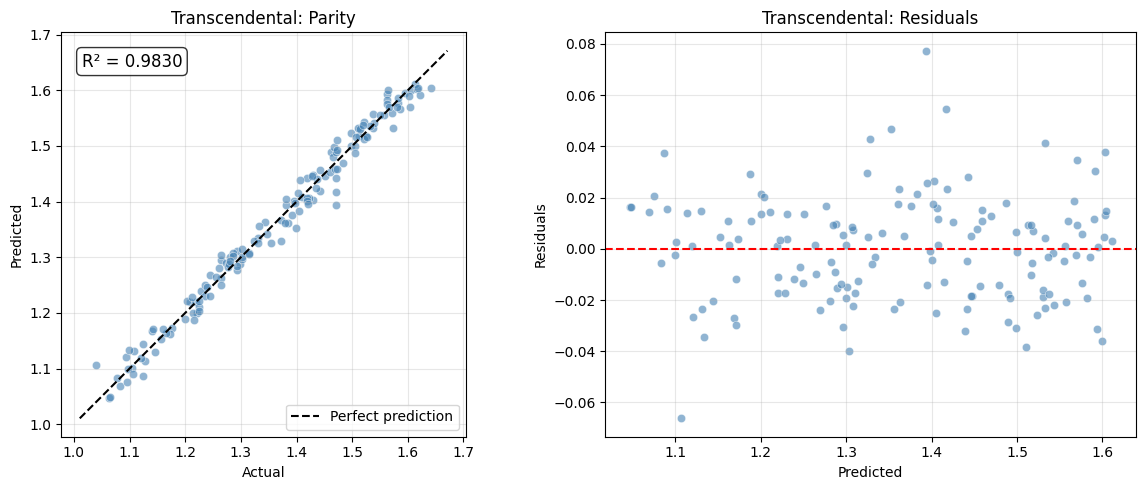


ANOVA Table (Transcendental)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  1                             1        0.0000        0.0000        0.00      1.0000
  sqrt(x)                       1        3.6862        3.6862     8490.58      0.0000
  exp(x)                        1        0.0048        0.0048       11.09      0.0011
  Model                         2        3.6910        1.8455     4250.83      0.0000
  Residual                    147        0.0638        0.0004                        
  Total                       149        3.7548        0.0252                        
--------------------------------------------------------------------------------

Variance Contributions:
  1                             0.0%  
  sqrt(x)                      99.9%  ***
  exp(x)                        0.1%  **


In [5]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y_jax)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_jax)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_jax, y_pred, ax=axes[0], title="Transcendental: Parity")
residuals = np.array(y_jax - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Transcendental: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Transcendental)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Use the fit_symbolic convenience function.

$$y = 3\,a^2 - 2\,b + 1$$

In [6]:
# Generate data
np.random.seed(42)
X = np.random.randn(100, 2)
y = 3.0 * X[:, 0] ** 2 - 2.0 * X[:, 1] + 1.0
y += np.random.randn(100) * 0.05

print("\nTrue model: y = 3*a^2 - 2*b + 1")

# Quick fit
model = fit_symbolic(
    jnp.array(X),
    jnp.array(y),
    feature_names=["a", "b"],
    max_terms=5,
    max_poly_degree=3,
)

print(f"\nDiscovered: {model.expression_}")
print(f"R² = {model.score(jnp.array(X), jnp.array(y)):.4f}")


True model: y = 3*a^2 - 2*b + 1


/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/regressor.py:1220: UserWarning: Removing 4 basis functions with non-finite values
  return model.fit(X, y)



Discovered: y = 3*a^2 - 2.008*b + 1.004
R² = 0.9998


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
              a^2     3.0000    0.0051   586.21   0.00e+00 [2.9899, 3.0102] ***
                b    -2.0083    0.0054  -368.80   0.00e+00 [-2.0192, -1.9975] ***
                1     1.0035    0.0066   151.93   0.00e+00 [0.9904, 1.0166] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


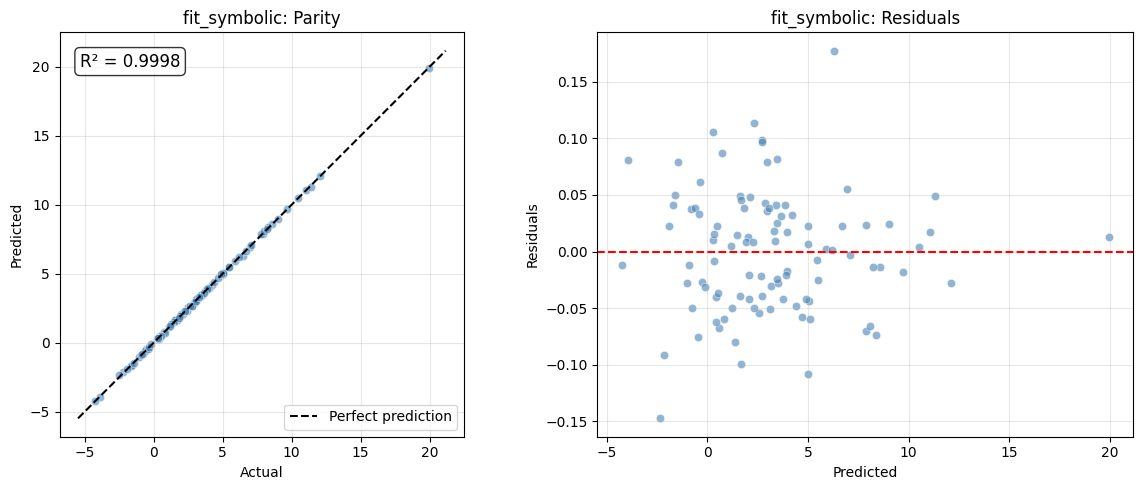


ANOVA Table (fit_symbolic)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  a^2                           1      936.0065      936.0065   319576.03      0.0000
  b                             1      390.9592      390.9592   133483.23      0.0000
  1                             1       67.6071       67.6071    23082.77      0.0000
  Model                         2     1394.5728      697.2864   238071.01      0.0000
  Residual                     97        0.2841        0.0029                        
  Total                        99     1394.8569       14.0895                        
--------------------------------------------------------------------------------

Variance Contributions:
  a^2                          67.1%  ***
  b                            28.0%  ***
  1                             4.8%  ***


In [7]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
X_fit, y_fit = jnp.array(X), jnp.array(y)
n_obs, k_terms = len(np.asarray(y_fit)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_fit)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_fit, y_pred, ax=axes[0], title="fit_symbolic: Parity")
residuals = np.array(y_fit - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("fit_symbolic: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (fit_symbolic)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Explore the Pareto front of complexity vs accuracy.

$$y = 2\,x + 1.5\,y^2 - 0.5\,x\,y$$

In [8]:
# Generate data
np.random.seed(42)
X = np.random.randn(150, 2)
y = 2.0 * X[:, 0] + 1.5 * X[:, 1] ** 2 - 0.5 * X[:, 0] * X[:, 1]
y += np.random.randn(150) * 0.1

X_jax = jnp.array(X)
y_jax = jnp.array(y)

library = (
    BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=6,
    strategy="greedy_forward",
)
model.fit(X_jax, y_jax)

print("\nPareto Front (Complexity vs MSE):")
for result in model.pareto_front_:
    print(f"  Complexity {result.complexity:2d} | MSE {result.mse:.6f}")
    print(f"    {result.expression()}")
    print()


Pareto Front (Complexity vs MSE):
  Complexity  2 | MSE 4.223643
    y = 1.63*y^2

  Complexity  3 | MSE 0.214977
    y = 1.496*y^2 + 2.091*x

  Complexity  5 | MSE 0.008936
    y = 1.497*y^2 + 2.002*x - 0.5041*x*y



Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
              y^2     1.4970    0.0041   367.58   0.00e+00 [1.4889, 1.5050] ***
                x     2.0018    0.0083   241.60   0.00e+00 [1.9854, 2.0182] ***
              x*y    -0.5041    0.0087   -58.22   0.00e+00 [-0.5212, -0.4870] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


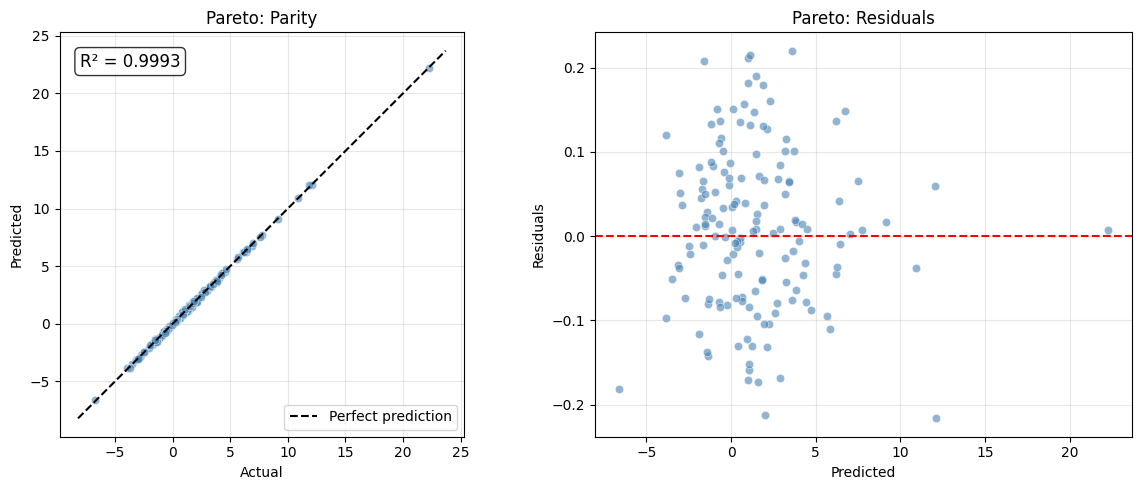


ANOVA Table (Pareto)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  y^2                           1     1172.4496     1172.4496   128582.51      0.0000
  x                             1      601.2999      601.2999    65944.54      0.0000
  x*y                           1       30.9062       30.9062     3389.48      0.0000
  Model                         2     1804.6557      902.3279    98958.27      0.0000
  Residual                    147        1.3404        0.0091                        
  Total                       149     1805.9961       12.1208                        
--------------------------------------------------------------------------------

Variance Contributions:
  y^2                          65.0%  ***
  x                            33.3%  ***
  x*y                           1.7%  ***


In [9]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y_jax)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_jax)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_jax, y_pred, ax=axes[0], title="Pareto: Parity")
residuals = np.array(y_jax - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Pareto: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Pareto)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Demonstrate model export capabilities.

In [10]:
# Generate and fit
np.random.seed(42)
X = np.random.randn(100, 2)
y = 2.0 * X[:, 0] + X[:, 1] ** 2

model = fit_symbolic(
    jnp.array(X),
    jnp.array(y),
    feature_names=["a", "b"],
    max_terms=4,
)

# Human-readable expression
print(f"\nExpression: {model.expression_}")

# SymPy export
try:
    sympy_expr = model.to_sympy()
    print(f"SymPy: {sympy_expr}")

    # LaTeX
    latex = model.to_latex()
    print(f"LaTeX: {latex}")
except ImportError:
    print("(SymPy not available for symbolic export)")

# Pure Python callable
predict_fn = model.to_callable()
X_test = np.array([[1.0, 2.0], [3.0, 4.0]])
y_pred = predict_fn(X_test)
print("\nPure NumPy predictions:")
print(f"  X = {X_test.tolist()}")
print(f"  y_pred = {y_pred.tolist()}")


Expression: y = 2*a + b^2


SymPy: 2.0*a + 1.00000011920929*b**2.0
LaTeX: 2.0 a + 1.00000011920929 b^{2.0}

Pure NumPy predictions:
  X = [[1.0, 2.0], [3.0, 4.0]]
  y_pred = [6.000000476837158, 22.000001907348633]


## Demonstrate uncertainty quantification.

In [11]:
# Generate data with known noise level
np.random.seed(42)
n_samples = 100
X = np.random.uniform(0, 5, (n_samples, 1))
y_true = 2.0 * X[:, 0] + 1.0
y = y_true + np.random.randn(n_samples) * 0.5

X_jax = jnp.array(X)
y_jax = jnp.array(y)

print("\nTrue model: y = 2*x + 1 (noise std = 0.5)")

# Fit model
library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=3,
    strategy="greedy_forward",
)
model.fit(X_jax, y_jax)

print(f"Discovered: {model.expression_}")
print(f"Estimated noise std: {model.sigma_:.4f} (true: 0.5)")

# Coefficient confidence intervals
print("\n95% coefficient intervals:")
for name, (est, lo, hi, se) in model.coefficient_intervals().items():
    print(f"  {name}: {est:.4f} [{lo:.4f}, {hi:.4f}]")

# Prediction intervals on new data
X_new = jnp.array([[1.0], [2.5], [4.0]])
y_pred, pred_lo, pred_hi = model.predict_interval(X_new)
y_pred_c, conf_lo, conf_hi = model.confidence_band(X_new)

print("\nPrediction vs confidence intervals:")
for i in range(3):
    x = float(X_new[i, 0])
    print(
        f"  x={x:.1f}: pred=[{float(pred_lo[i]):.2f}, {float(pred_hi[i]):.2f}], "
        f"conf=[{float(conf_lo[i]):.2f}, {float(conf_hi[i]):.2f}]"
    )

# Conformal prediction (distribution-free)
y_pred_conf, lo_conf, hi_conf = model.predict_conformal(X_new, alpha=0.05)
print("\nConformal 95% intervals (Jackknife+):")
for i in range(3):
    x = float(X_new[i, 0])
    print(f"  x={x:.1f}: [{float(lo_conf[i]):.2f}, {float(hi_conf[i]):.2f}]")


True model: y = 2*x + 1 (noise std = 0.5)


Discovered: y = 1.954*x + 1.108


Estimated noise std: 0.4536 (true: 0.5)

95% coefficient intervals:
  x: 1.9540 [1.8932, 2.0148]
  1: 1.1075 [0.9386, 1.2765]



Prediction vs confidence intervals:
  x=1.0: pred=[2.15, 3.97], conf=[2.94, 3.18]
  x=2.5: pred=[5.09, 6.90], conf=[5.90, 6.08]
  x=4.0: pred=[8.01, 9.83], conf=[8.79, 9.06]

Conformal 95% intervals (Jackknife+):
  x=1.0: [2.07, 4.05]
  x=2.5: [5.00, 6.98]
  x=4.0: [7.94, 9.91]
